# Loading Modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from what_where.main import init, MNIST
from what_where.what import WhatShift, WhatBackground, WhatNet
from stn import STN
from utils import view_dataset

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [2]:
args = init(filename='what_where/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [3]:
transform=transforms.Compose([
                               WhatShift(args),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           #transforms.Normalize((0.4914,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

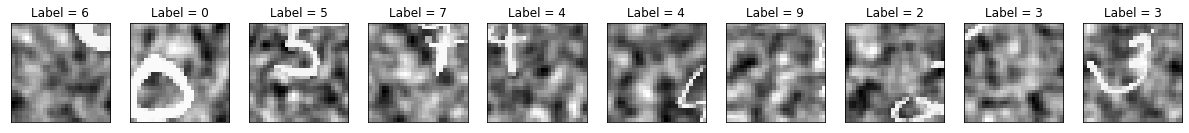

In [4]:
data = view_dataset(train_loader)
#data.savefig('../figures/noisy_no_shift_28x28_data.png')

# Spatial Transformer Network

In [5]:
def train(epoch, loader):

    epoch_loss= []
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, args.epochs, batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), batch_loss))
        epoch_loss.append(batch_loss)
    #loss_vals.append(sum(epoch_loss)/len(epoch_loss))


def test(loader):

    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in loader:
            data, target = data.to(device,
                                   dtype=torch.float), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        acc = correct / len(test_loader.dataset)
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset),
                     100. * acc))
        return acc
        #acc_vals.append(acc)

In [14]:
for ofst in range(15 + 1):

    args.what_offset_std = ofst
    print("Training on offset_std = %s" % (args.what_offset_std))
    transform = transforms.Compose([
        WhatShift(args),
        WhatBackground(contrast=args.contrast,
                       noise=args.noise,
                       sf_0=args.sf_0,
                       B_sf=args.B_sf),
        transforms.ToTensor(),
        #transforms.Normalize((args.mean,), (args.std,))
    ])

    train_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=True,
        download=True,
        transform=transform,
    ),
                                               batch_size=args.minibatch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(MNIST(
        '../data',
        train=False,
        download=True,
        transform=transform,
    ),
                                              batch_size=args.minibatch_size,
                                              shuffle=True)

    args.epochs = 20
    for epoch in range(1, args.epochs + 1):
        train(epoch, train_loader) 
        test(test_loader)
        #stn_grid(epoch)

Training on offset_std = 0
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 2.301564
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 2.301821
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 2.295257
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 2.288388
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 2.287042
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 2.275207

Test set: Average loss: 0.0226, Accuracy: 3093/10000 (31%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 2.275236
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 2.238195
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 2.188063
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 2.100445
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 1.827357
Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 1.340720

Test set: Average loss: 0.0120, Accuracy: 6064/10000 (61%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 1.340488
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 1.272444
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 1.079010
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.020007
Train Epoch: 3/20 

Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 0.121147

Test set: Average loss: 0.0016, Accuracy: 9478/10000 (95%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 0.211056
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 0.089908
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 0.199895
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 0.223756
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 0.113149
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 0.214218

Test set: Average loss: 0.0014, Accuracy: 9563/10000 (96%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 0.096112
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.059263
Train Epoch: 4/20 [20000/60000 (33%)]	Loss: 0.131482
Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 0.063505
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 0.104984
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 0.207071

Test set: Average loss: 0.0015, Accuracy: 9497/10000 (95%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 0.149401
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 0.167713
Train Epoch: 5/20 [20000/60000 (33%)]

Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 0.046947
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 0.137772
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 0.241129

Test set: Average loss: 0.0013, Accuracy: 9599/10000 (96%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 0.135777
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 0.092521
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 0.187160
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 0.056697
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 0.154566
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 0.068988

Test set: Average loss: 0.0015, Accuracy: 9524/10000 (95%)

Train Epoch: 6/20 [0/60000 (0%)]	Loss: 0.227380
Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 0.054003
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 0.117700
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 0.180451
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 0.125403
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 0.171331

Test set: Average loss: 0.0012, Accuracy: 9590/10000 (96%)

Train Epoch: 7/20 [0/60000 (0%)]

Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 0.128089
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 0.098647
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 0.058171
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 0.098468
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 0.144978

Test set: Average loss: 0.0015, Accuracy: 9527/10000 (95%)

Train Epoch: 7/20 [0/60000 (0%)]	Loss: 0.137524
Train Epoch: 7/20 [10000/60000 (17%)]	Loss: 0.106012
Train Epoch: 7/20 [20000/60000 (33%)]	Loss: 0.179465
Train Epoch: 7/20 [30000/60000 (50%)]	Loss: 0.101916
Train Epoch: 7/20 [40000/60000 (67%)]	Loss: 0.114742
Train Epoch: 7/20 [50000/60000 (83%)]	Loss: 0.259512

Test set: Average loss: 0.0017, Accuracy: 9448/10000 (94%)

Train Epoch: 8/20 [0/60000 (0%)]	Loss: 0.256138
Train Epoch: 8/20 [10000/60000 (17%)]	Loss: 0.096897
Train Epoch: 8/20 [20000/60000 (33%)]	Loss: 0.067919
Train Epoch: 8/20 [30000/60000 (50%)]	Loss: 0.215535
Train Epoch: 8/20 [40000/60000 (67%)]	Loss: 0.220933
Train Epoch: 8/20 [50000/60000 (83%)]	Lo


Test set: Average loss: 0.0018, Accuracy: 9439/10000 (94%)

Train Epoch: 8/20 [0/60000 (0%)]	Loss: 0.269723
Train Epoch: 8/20 [10000/60000 (17%)]	Loss: 0.092534
Train Epoch: 8/20 [20000/60000 (33%)]	Loss: 0.300711
Train Epoch: 8/20 [30000/60000 (50%)]	Loss: 0.253652
Train Epoch: 8/20 [40000/60000 (67%)]	Loss: 0.164607
Train Epoch: 8/20 [50000/60000 (83%)]	Loss: 0.292578

Test set: Average loss: 0.0017, Accuracy: 9455/10000 (95%)

Train Epoch: 9/20 [0/60000 (0%)]	Loss: 0.184680
Train Epoch: 9/20 [10000/60000 (17%)]	Loss: 0.099491
Train Epoch: 9/20 [20000/60000 (33%)]	Loss: 0.175498
Train Epoch: 9/20 [30000/60000 (50%)]	Loss: 0.148445
Train Epoch: 9/20 [40000/60000 (67%)]	Loss: 0.107281
Train Epoch: 9/20 [50000/60000 (83%)]	Loss: 0.087481

Test set: Average loss: 0.0017, Accuracy: 9483/10000 (95%)

Train Epoch: 10/20 [0/60000 (0%)]	Loss: 0.064741
Train Epoch: 10/20 [10000/60000 (17%)]	Loss: 0.151733
Train Epoch: 10/20 [20000/60000 (33%)]	Loss: 0.167744
Train Epoch: 10/20 [30000/60000 (5

Train Epoch: 9/20 [40000/60000 (67%)]	Loss: 0.448788
Train Epoch: 9/20 [50000/60000 (83%)]	Loss: 0.375419

Test set: Average loss: 0.0025, Accuracy: 9209/10000 (92%)

Train Epoch: 10/20 [0/60000 (0%)]	Loss: 0.265574
Train Epoch: 10/20 [10000/60000 (17%)]	Loss: 0.124852
Train Epoch: 10/20 [20000/60000 (33%)]	Loss: 0.255133
Train Epoch: 10/20 [30000/60000 (50%)]	Loss: 0.167106
Train Epoch: 10/20 [40000/60000 (67%)]	Loss: 0.123470
Train Epoch: 10/20 [50000/60000 (83%)]	Loss: 0.228243

Test set: Average loss: 0.0021, Accuracy: 9323/10000 (93%)

Train Epoch: 11/20 [0/60000 (0%)]	Loss: 0.230088
Train Epoch: 11/20 [10000/60000 (17%)]	Loss: 0.147453
Train Epoch: 11/20 [20000/60000 (33%)]	Loss: 0.139415
Train Epoch: 11/20 [30000/60000 (50%)]	Loss: 0.220513
Train Epoch: 11/20 [40000/60000 (67%)]	Loss: 0.191851
Train Epoch: 11/20 [50000/60000 (83%)]	Loss: 0.176759

Test set: Average loss: 0.0027, Accuracy: 9158/10000 (92%)

Train Epoch: 12/20 [0/60000 (0%)]	Loss: 0.239431
Train Epoch: 12/20 [1000

Train Epoch: 11/20 [20000/60000 (33%)]	Loss: 0.262537
Train Epoch: 11/20 [30000/60000 (50%)]	Loss: 0.262222
Train Epoch: 11/20 [40000/60000 (67%)]	Loss: 0.244906
Train Epoch: 11/20 [50000/60000 (83%)]	Loss: 0.258593

Test set: Average loss: 0.0030, Accuracy: 9012/10000 (90%)

Train Epoch: 12/20 [0/60000 (0%)]	Loss: 0.298119
Train Epoch: 12/20 [10000/60000 (17%)]	Loss: 0.300799
Train Epoch: 12/20 [20000/60000 (33%)]	Loss: 0.355070
Train Epoch: 12/20 [30000/60000 (50%)]	Loss: 0.229804
Train Epoch: 12/20 [40000/60000 (67%)]	Loss: 0.229236
Train Epoch: 12/20 [50000/60000 (83%)]	Loss: 0.212763

Test set: Average loss: 0.0029, Accuracy: 9052/10000 (91%)

Train Epoch: 13/20 [0/60000 (0%)]	Loss: 0.328215
Train Epoch: 13/20 [10000/60000 (17%)]	Loss: 0.254899
Train Epoch: 13/20 [20000/60000 (33%)]	Loss: 0.205881
Train Epoch: 13/20 [30000/60000 (50%)]	Loss: 0.297645
Train Epoch: 13/20 [40000/60000 (67%)]	Loss: 0.224979
Train Epoch: 13/20 [50000/60000 (83%)]	Loss: 0.312688

Test set: Average loss:

Train Epoch: 13/20 [10000/60000 (17%)]	Loss: 0.459042
Train Epoch: 13/20 [20000/60000 (33%)]	Loss: 0.794499
Train Epoch: 13/20 [30000/60000 (50%)]	Loss: 0.427405
Train Epoch: 13/20 [40000/60000 (67%)]	Loss: 0.281270
Train Epoch: 13/20 [50000/60000 (83%)]	Loss: 0.275181

Test set: Average loss: 0.0040, Accuracy: 8656/10000 (87%)

Train Epoch: 14/20 [0/60000 (0%)]	Loss: 0.327808
Train Epoch: 14/20 [10000/60000 (17%)]	Loss: 0.401660
Train Epoch: 14/20 [20000/60000 (33%)]	Loss: 0.218914
Train Epoch: 14/20 [30000/60000 (50%)]	Loss: 0.274541
Train Epoch: 14/20 [40000/60000 (67%)]	Loss: 0.286847
Train Epoch: 14/20 [50000/60000 (83%)]	Loss: 0.346486

Test set: Average loss: 0.0039, Accuracy: 8680/10000 (87%)

Train Epoch: 15/20 [0/60000 (0%)]	Loss: 0.511292
Train Epoch: 15/20 [10000/60000 (17%)]	Loss: 0.421459
Train Epoch: 15/20 [20000/60000 (33%)]	Loss: 0.417946
Train Epoch: 15/20 [30000/60000 (50%)]	Loss: 0.378194
Train Epoch: 15/20 [40000/60000 (67%)]	Loss: 0.291232
Train Epoch: 15/20 [5000


Test set: Average loss: 0.0047, Accuracy: 8362/10000 (84%)

Train Epoch: 15/20 [0/60000 (0%)]	Loss: 0.476812
Train Epoch: 15/20 [10000/60000 (17%)]	Loss: 0.314244
Train Epoch: 15/20 [20000/60000 (33%)]	Loss: 0.377867
Train Epoch: 15/20 [30000/60000 (50%)]	Loss: 0.482441
Train Epoch: 15/20 [40000/60000 (67%)]	Loss: 0.427791
Train Epoch: 15/20 [50000/60000 (83%)]	Loss: 0.352145

Test set: Average loss: 0.0047, Accuracy: 8385/10000 (84%)

Train Epoch: 16/20 [0/60000 (0%)]	Loss: 0.513845
Train Epoch: 16/20 [10000/60000 (17%)]	Loss: 0.261480
Train Epoch: 16/20 [20000/60000 (33%)]	Loss: 0.487962
Train Epoch: 16/20 [30000/60000 (50%)]	Loss: 0.475769
Train Epoch: 16/20 [40000/60000 (67%)]	Loss: 0.424713
Train Epoch: 16/20 [50000/60000 (83%)]	Loss: 0.548000

Test set: Average loss: 0.0048, Accuracy: 8340/10000 (83%)

Train Epoch: 17/20 [0/60000 (0%)]	Loss: 0.566744
Train Epoch: 17/20 [10000/60000 (17%)]	Loss: 0.459514
Train Epoch: 17/20 [20000/60000 (33%)]	Loss: 0.564804
Train Epoch: 17/20 [30

Train Epoch: 16/20 [40000/60000 (67%)]	Loss: 0.560799
Train Epoch: 16/20 [50000/60000 (83%)]	Loss: 0.761622

Test set: Average loss: 0.0059, Accuracy: 7939/10000 (79%)

Train Epoch: 17/20 [0/60000 (0%)]	Loss: 0.464750
Train Epoch: 17/20 [10000/60000 (17%)]	Loss: 0.486636
Train Epoch: 17/20 [20000/60000 (33%)]	Loss: 0.483197
Train Epoch: 17/20 [30000/60000 (50%)]	Loss: 0.544355
Train Epoch: 17/20 [40000/60000 (67%)]	Loss: 0.567734
Train Epoch: 17/20 [50000/60000 (83%)]	Loss: 0.547845

Test set: Average loss: 0.0060, Accuracy: 7923/10000 (79%)

Train Epoch: 18/20 [0/60000 (0%)]	Loss: 0.458128
Train Epoch: 18/20 [10000/60000 (17%)]	Loss: 0.422192
Train Epoch: 18/20 [20000/60000 (33%)]	Loss: 0.506349
Train Epoch: 18/20 [30000/60000 (50%)]	Loss: 0.795909
Train Epoch: 18/20 [40000/60000 (67%)]	Loss: 0.620949
Train Epoch: 18/20 [50000/60000 (83%)]	Loss: 0.765837

Test set: Average loss: 0.0060, Accuracy: 7880/10000 (79%)

Train Epoch: 19/20 [0/60000 (0%)]	Loss: 0.545045
Train Epoch: 19/20 [10

Train Epoch: 18/20 [20000/60000 (33%)]	Loss: 0.659015
Train Epoch: 18/20 [30000/60000 (50%)]	Loss: 0.891503
Train Epoch: 18/20 [40000/60000 (67%)]	Loss: 0.668302
Train Epoch: 18/20 [50000/60000 (83%)]	Loss: 0.600756

Test set: Average loss: 0.0072, Accuracy: 7409/10000 (74%)

Train Epoch: 19/20 [0/60000 (0%)]	Loss: 0.518190
Train Epoch: 19/20 [10000/60000 (17%)]	Loss: 0.744788
Train Epoch: 19/20 [20000/60000 (33%)]	Loss: 0.784824
Train Epoch: 19/20 [30000/60000 (50%)]	Loss: 0.882123
Train Epoch: 19/20 [40000/60000 (67%)]	Loss: 0.656532
Train Epoch: 19/20 [50000/60000 (83%)]	Loss: 0.652675

Test set: Average loss: 0.0074, Accuracy: 7345/10000 (73%)

Train Epoch: 20/20 [0/60000 (0%)]	Loss: 0.841133
Train Epoch: 20/20 [10000/60000 (17%)]	Loss: 0.768992
Train Epoch: 20/20 [20000/60000 (33%)]	Loss: 0.528756
Train Epoch: 20/20 [30000/60000 (50%)]	Loss: 0.742174
Train Epoch: 20/20 [40000/60000 (67%)]	Loss: 0.778746
Train Epoch: 20/20 [50000/60000 (83%)]	Loss: 0.815610

Test set: Average loss:

Train Epoch: 20/20 [10000/60000 (17%)]	Loss: 0.724990
Train Epoch: 20/20 [20000/60000 (33%)]	Loss: 0.653554
Train Epoch: 20/20 [30000/60000 (50%)]	Loss: 0.678906
Train Epoch: 20/20 [40000/60000 (67%)]	Loss: 0.830141
Train Epoch: 20/20 [50000/60000 (83%)]	Loss: 0.969266

Test set: Average loss: 0.0083, Accuracy: 6971/10000 (70%)

Training on offset_std = 12
Train Epoch: 1/20 [0/60000 (0%)]	Loss: 0.778030
Train Epoch: 1/20 [10000/60000 (17%)]	Loss: 1.086391
Train Epoch: 1/20 [20000/60000 (33%)]	Loss: 0.934902
Train Epoch: 1/20 [30000/60000 (50%)]	Loss: 0.901669
Train Epoch: 1/20 [40000/60000 (67%)]	Loss: 0.962640
Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 1.227640

Test set: Average loss: 0.0101, Accuracy: 6357/10000 (64%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 1.025842
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 1.041632
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 0.968794
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 0.784766
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 0.814279
Train E

Train Epoch: 1/20 [50000/60000 (83%)]	Loss: 1.126816

Test set: Average loss: 0.0106, Accuracy: 6061/10000 (61%)

Train Epoch: 2/20 [0/60000 (0%)]	Loss: 0.998577
Train Epoch: 2/20 [10000/60000 (17%)]	Loss: 1.148548
Train Epoch: 2/20 [20000/60000 (33%)]	Loss: 1.145619
Train Epoch: 2/20 [30000/60000 (50%)]	Loss: 1.193216
Train Epoch: 2/20 [40000/60000 (67%)]	Loss: 1.260584
Train Epoch: 2/20 [50000/60000 (83%)]	Loss: 1.076082

Test set: Average loss: 0.0107, Accuracy: 6003/10000 (60%)

Train Epoch: 3/20 [0/60000 (0%)]	Loss: 1.207011
Train Epoch: 3/20 [10000/60000 (17%)]	Loss: 0.970871
Train Epoch: 3/20 [20000/60000 (33%)]	Loss: 1.064354
Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.311860
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 1.100274
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 1.372355

Test set: Average loss: 0.0109, Accuracy: 5987/10000 (60%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 1.105089
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.945784
Train Epoch: 4/20 [20000/60000 (33%)]

Train Epoch: 3/20 [30000/60000 (50%)]	Loss: 1.136672
Train Epoch: 3/20 [40000/60000 (67%)]	Loss: 1.230954
Train Epoch: 3/20 [50000/60000 (83%)]	Loss: 1.304107

Test set: Average loss: 0.0120, Accuracy: 5560/10000 (56%)

Train Epoch: 4/20 [0/60000 (0%)]	Loss: 1.132296
Train Epoch: 4/20 [10000/60000 (17%)]	Loss: 0.993412
Train Epoch: 4/20 [20000/60000 (33%)]	Loss: 1.153243
Train Epoch: 4/20 [30000/60000 (50%)]	Loss: 1.108344
Train Epoch: 4/20 [40000/60000 (67%)]	Loss: 1.112004
Train Epoch: 4/20 [50000/60000 (83%)]	Loss: 1.281973

Test set: Average loss: 0.0133, Accuracy: 5080/10000 (51%)

Train Epoch: 5/20 [0/60000 (0%)]	Loss: 1.321393
Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 1.253626
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 1.324654
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 1.173983
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 1.208097
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 1.196138

Test set: Average loss: 0.0126, Accuracy: 5347/10000 (53%)

Train Epoch: 6/20 [0/60000 (0%)]

Train Epoch: 5/20 [10000/60000 (17%)]	Loss: 1.442459
Train Epoch: 5/20 [20000/60000 (33%)]	Loss: 1.378261
Train Epoch: 5/20 [30000/60000 (50%)]	Loss: 1.515598
Train Epoch: 5/20 [40000/60000 (67%)]	Loss: 1.197315
Train Epoch: 5/20 [50000/60000 (83%)]	Loss: 1.056522

Test set: Average loss: 0.0132, Accuracy: 5095/10000 (51%)

Train Epoch: 6/20 [0/60000 (0%)]	Loss: 1.422606
Train Epoch: 6/20 [10000/60000 (17%)]	Loss: 1.213313
Train Epoch: 6/20 [20000/60000 (33%)]	Loss: 1.590998
Train Epoch: 6/20 [30000/60000 (50%)]	Loss: 1.361583
Train Epoch: 6/20 [40000/60000 (67%)]	Loss: 1.370983
Train Epoch: 6/20 [50000/60000 (83%)]	Loss: 1.374701

Test set: Average loss: 0.0133, Accuracy: 5114/10000 (51%)

Train Epoch: 7/20 [0/60000 (0%)]	Loss: 1.379676
Train Epoch: 7/20 [10000/60000 (17%)]	Loss: 1.217147
Train Epoch: 7/20 [20000/60000 (33%)]	Loss: 1.391237
Train Epoch: 7/20 [30000/60000 (50%)]	Loss: 1.374841
Train Epoch: 7/20 [40000/60000 (67%)]	Loss: 1.308931
Train Epoch: 7/20 [50000/60000 (83%)]	Lo

In [15]:
args.what_offset_std = 7
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    return inp

thetas = []
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0][:64, :, :, :].to(device) # taking only a batch of 64 for a better plot

        input_tensor = data.cpu()
        
        output_tensor, theta = model.transformer_module.stn(data)
        thetas.append(theta)
        
        transformed_input_tensor = output_tensor.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2, dpi=300)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        #f.savefig('../figures/results_trained.png')

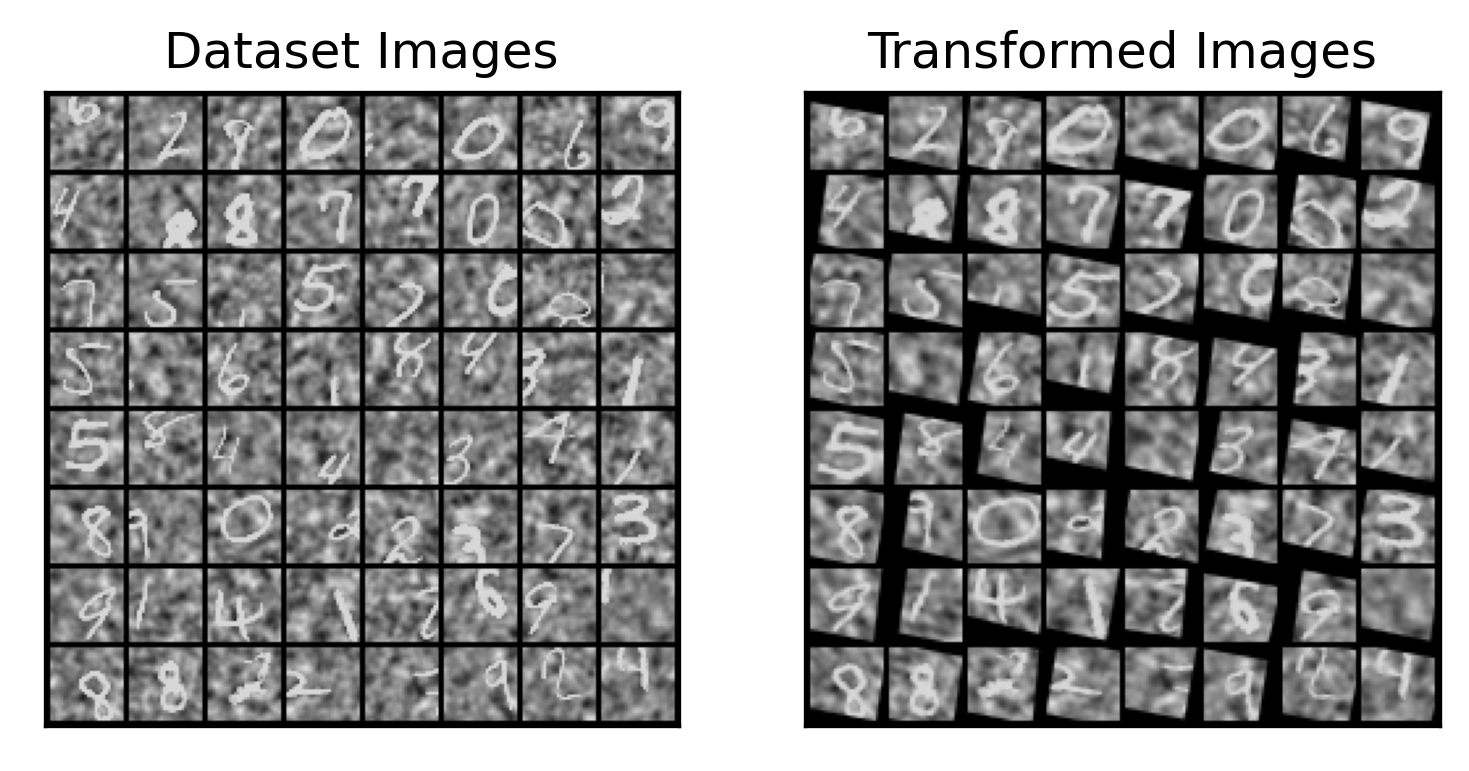

In [16]:
visualize_stn()

In [12]:
thetas

[tensor([[[ 8.5710e-01,  1.7259e-01, -9.3902e-04],
          [-1.9234e-01,  9.0883e-01,  2.4377e-01]],
 
         [[ 8.3773e-01,  1.3242e-01,  4.5758e-01],
          [-1.8404e-01,  9.7442e-01, -3.5786e-01]],
 
         [[ 8.2400e-01,  1.6940e-01, -1.7572e-01],
          [-1.7888e-01,  9.3160e-01, -1.5550e-01]],
 
         [[ 8.4584e-01,  1.3748e-01,  3.7320e-01],
          [-1.8021e-01,  9.6630e-01, -3.1880e-01]],
 
         [[ 7.7747e-01,  1.0548e-01,  6.1816e-01],
          [-1.7427e-01,  9.8998e-01, -1.9776e-01]],
 
         [[ 8.9129e-01,  1.3342e-01, -4.5355e-02],
          [-1.8495e-01,  9.6089e-01, -9.9528e-02]],
 
         [[ 8.5792e-01,  1.5625e-01,  1.3760e-01],
          [-1.8835e-01,  9.2963e-01,  4.6518e-02]],
 
         [[ 8.5815e-01,  1.6931e-01,  6.7139e-03],
          [-1.7372e-01,  9.2997e-01, -3.5418e-01]],
 
         [[ 8.0177e-01,  1.2041e-01,  5.4262e-01],
          [-1.7191e-01,  9.7928e-01, -2.3910e-01]],
 
         [[ 8.7400e-01,  1.0635e-01,  3.7584e-01],
    

# Saving the model

In [6]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../models/stn_28x28_shift_dependant_sgd.pt"
#torch.save(model, PATH)

# General accuracy

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(PATH).to(device)
#model = STN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()#model = STN().to(device)
#loss_vals=  []
#acc_vals = []

In [9]:
args.what_offset_std = 15

In [10]:
test(test_loader)


Test set: Average loss: 0.0131, Accuracy: 5134/10000 (51%)



0.5134

# Central accuracy

In [11]:
args.what_offset_std = 0
test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)

In [12]:
test(test_loader)


Test set: Average loss: 0.0012, Accuracy: 9644/10000 (96%)



0.9644

# Loss and accuracy over epochs

In [3]:
acc_vals = [
    0.3093, 0.6064, 0.7432, 0.8021, 0.8583, 0.8845, 0.9075, 0.9219, 0.9333,
    0.937, 0.9444, 0.9451, 0.95, 0.9486, 0.9542, 0.9496, 0.959, 0.9592, 0.962,
    0.9603, 0.9506, 0.9478, 0.9563, 0.9497, 0.9621, 0.9599, 0.9644, 0.9636,
    0.9585, 0.9655, 0.9663, 0.9633, 0.9652, 0.9664, 0.9672, 0.9688, 0.9666,
    0.9691, 0.9686, 0.97, 0.9505, 0.9518, 0.9558, 0.9599, 0.9524, 0.959,
    0.9581, 0.962, 0.955, 0.9634, 0.9654, 0.9571, 0.9649, 0.9624, 0.965,
    0.9647, 0.9642, 0.9687, 0.9653, 0.9664, 0.9477, 0.9403, 0.9477, 0.9455,
    0.9507, 0.9527, 0.9448, 0.948, 0.9577, 0.9569, 0.9555, 0.9605, 0.9615,
    0.9568, 0.9607, 0.9522, 0.9598, 0.9514, 0.9625, 0.9611, 0.9327, 0.9195,
    0.9368, 0.942, 0.9444, 0.9424, 0.9439, 0.9455, 0.9483, 0.9488, 0.9512,
    0.9421, 0.9415, 0.9474, 0.9347, 0.9551, 0.9472, 0.9512, 0.9545, 0.9553,
    0.9222, 0.917, 0.9219, 0.9265, 0.9238, 0.9307, 0.9314, 0.9319, 0.9209,
    0.9323, 0.9158, 0.9219, 0.9308, 0.9348, 0.935, 0.9301, 0.9322, 0.9249,
    0.9287, 0.9358, 0.8971, 0.8923, 0.8993, 0.9009, 0.9023, 0.9025, 0.9052,
    0.8909, 0.8906, 0.9, 0.9012, 0.9052, 0.9085, 0.8967, 0.9041, 0.8978,
    0.9113, 0.91, 0.9081, 0.9097, 0.8684, 0.8682, 0.8697, 0.866, 0.8709,
    0.8728, 0.874, 0.875, 0.8738, 0.8797, 0.8692, 0.8686, 0.8656, 0.868,
    0.7876, 0.8718, 0.8801, 0.8831, 0.8737, 0.8806, 0.8215, 0.8338, 0.8052,
    0.8261, 0.8244, 0.8201, 0.8346, 0.8153, 0.8349, 0.834, 0.8331, 0.8161,
    0.8205, 0.8362, 0.8385, 0.834, 0.8304, 0.834, 0.8355, 0.8006, 0.7811,
    0.7837, 0.7777, 0.7983, 0.7792, 0.7724, 0.79, 0.7638, 0.7922, 0.7905,
    0.7783, 0.7957, 0.7866, 0.7971, 0.7948, 0.7939, 0.7923, 0.788, 0.7988,
    0.8003, 0.7363, 0.7386, 0.744, 0.7198, 0.7241, 0.7278, 0.738, 0.742,
    0.7327, 0.7394, 0.7367, 0.7522, 0.7469, 0.7428, 0.7321, 0.741, 0.7424,
    0.7409, 0.7345, 0.6945, 0.698, 0.684, 0.6984, 0.6945, 0.6925, 0.7026,
    0.6688, 0.6958, 0.6711, 0.6992, 0.7047, 0.7018, 0.6944, 0.6847, 0.6602,
    0.6886, 0.6884, 0.6953, 0.6965, 0.6971, 0.6357, 0.6467, 0.6381, 0.6521,
    0.6402, 0.6488, 0.6165, 0.6395, 0.6449, 0.6415, 0.6535, 0.6518, 0.6367,
    0.6291, 0.6515, 0.6497, 0.6391, 0.6516, 0.6444, 0.6428, 0.6061, 0.6003,
    0.5987, 0.6019, 0.6122, 0.6077, 0.5956, 0.591, 0.6095, 0.585, 0.6116,
    0.5949, 0.5907, 0.6003, 0.6018, 0.6103, 0.6029, 0.6142, 0.6059, 0.6059,
    0.5517, 0.5482, 0.556, 0.508, 0.5347, 0.5445, 0.5571, 0.5501, 0.5664,
    0.5662, 0.5287, 0.5548, 0.5552, 0.5507, 0.5554, 0.5531, 0.5655, 0.5445,
    0.5625, 0.5712, 0.5277, 0.522, 0.5318, 0.5182, 0.5095, 0.5114, 0.5181,
    0.5212, 0.5283, 0.5147, 0.5272, 0.5294, 0.4962, 0.5075, 0.5266, 0.5297,
    0.5301, 0.5324, 0.5336, 0.5134
]

loss_vals = [
    2.286695384979248, 1.9285496163368225, 0.9803406612078349,
    0.745513089299202, 0.5689755832652251, 0.43876292002697787,
    0.35076369387408096, 0.2929309501250585, 0.2590188171466192,
    0.22812861517071725, 0.20769931059951582, 0.18959866668408115,
    0.17777793399368724, 0.16447451944152514, 0.15243016785010696,
    0.14431485838877658, 0.13716018924800058, 0.12999546478812893,
    0.12476990952156485, 0.11937916751950979, 0.1933037592843175,
    0.17068537377441922, 0.15579542001709343, 0.14656712089975674,
    0.13938486704602837, 0.1326268125884235, 0.1281212023148934,
    0.12241021792093913, 0.11847146552987396, 0.1136555099238952,
    0.10872118018257121, 0.10586627492681146, 0.10156805622701844,
    0.09925980080539981, 0.09659668372943997, 0.09322806113399565,
    0.09103941322304308, 0.0887959790059055, 0.08655453649970392,
    0.08500339422064523, 0.22546676762402057, 0.18375772616515557,
    0.16663298008963465, 0.15446368709827463, 0.1441217488485078,
    0.1393447108628849, 0.1314802111250659, 0.12679938457285364,
    0.12032857798039913, 0.11840867701917887, 0.11364443689274291,
    0.10952643277123571, 0.10648028215393424, 0.10479494313088557,
    0.10366520506640275, 0.09893041216457883, 0.09546529076683025,
    0.09310287557542324, 0.09238427723447482, 0.08902628708009919,
    0.2160568372098108, 0.19054939072579147, 0.17766483038663863,
    0.16786772625520827, 0.15788700584322213, 0.1528766418931385,
    0.14886249623882275, 0.14322721971198915, 0.1354873503589382,
    0.13503083048698802, 0.1307588328110675, 0.12424280357236664,
    0.1228119407594204, 0.12224273975628118, 0.11680992547112207,
    0.11177853544553121, 0.11201810665739079, 0.10823331524307529,
    0.10595688848135372, 0.10180886659150322, 0.24691160878787438,
    0.22476880957062045, 0.2100762023528417, 0.2006059321636955,
    0.1896305793710053, 0.1821620026603341, 0.17447087882707515,
    0.1726596702883641, 0.1682114413504799, 0.16406465136756498,
    0.1570504580810666, 0.15378655940294267, 0.1510779425005118,
    0.15169221791128318, 0.1437487336496512, 0.14097067082921663,
    0.1386356999973456, 0.13607812485968074, 0.13192553758621217,
    0.1310085434342424, 0.2978735227882862, 0.27207673008243244,
    0.2598241294672092, 0.24846215926110746, 0.24569567184895277,
    0.23863548927009107, 0.22904819707075755, 0.2239153764521082,
    0.22296353539451957, 0.21244219480703275, 0.21065229516476391,
    0.20989365650340916, 0.20612819800153376, 0.2015946024345855,
    0.19760200964907806, 0.196468978288273, 0.1932240015330414,
    0.18858338555321097, 0.18572590930387378, 0.18438673769434294,
    0.35575153614083926, 0.3358966539551814, 0.3288193461547295,
    0.32047019315262637, 0.3135875387365619, 0.30711392803738513,
    0.29791504292438425, 0.2918439736093084, 0.2893299739435315,
    0.28481388056029877, 0.2820868552600344, 0.27932813188682,
    0.27574617192149165, 0.26881649900227783, 0.26839898224920034,
    0.2658214924360315, 0.2596364329382777, 0.2586798575396339,
    0.25193959758927426, 0.2556170127292474, 0.4307006043444077,
    0.4202891017993291, 0.41588859535753725, 0.40387813416620094,
    0.39583280617992084, 0.3930962899327278, 0.3824352244287729,
    0.3770197179168463, 0.3846123411009709, 0.3719363014648358,
    0.37053963748117286, 0.3678762797266245, 0.3655950601398945,
    0.3598873085528612, 0.3554203415537874, 0.3591125489274661,
    0.35298085771501064, 0.35008618772029876, 0.34954101987183095,
    0.34541631132364276, 0.5234539111206928, 0.5163691710432371,
    0.5160775946080685, 0.5027624617268642, 0.4908181332796812,
    0.4958469774325689, 0.4881361757715543, 0.4843935344616572,
    0.477956637814641, 0.47738929994404317, 0.47127946140865484,
    0.4718810979773601, 0.4719842283924421, 0.4640361305574576,
    0.45980036824941634, 0.4616509608924389, 0.45768639236688613,
    0.4624459555496772, 0.4551541845748822, 0.4516192486633857,
    0.6139048218230406, 0.6220993551115195, 0.6118884279330572,
    0.6046777120232583, 0.6095265379548073, 0.6033446672062079,
    0.6124149546523889, 0.5892090325057506, 0.5929870191713175,
    0.5921253895759583, 0.5963891543447971, 0.5904057603577773,
    0.5835660214225451, 0.5844400891661644, 0.5739727887511253,
    0.5772351922591528, 0.5787807287772496, 0.5759148430327574,
    0.5733624572058519, 0.5674678403139114, 0.7553241026401519,
    0.7421118717392285, 0.7475462715824445, 0.7388891068100929,
    0.7408417441447576, 0.769106551806132, 0.7311865701774756,
    0.7242196774482728, 0.7666522787014644, 0.7422886611521244,
    0.7244569199283918, 0.7236938532193502, 0.7111980231106281,
    0.718111130297184, 0.7178975682953993, 0.712137325356404,
    0.7181961663564046, 0.7066147999465465, 0.7072034937640032,
    0.7130676250159741, 0.8674844770630201, 0.8823193867007891,
    0.8844042292237282, 0.8753126659989356, 0.8721135026216507,
    0.8661978072921435, 0.8740030404925346, 0.8768836892644565,
    0.8488577221830685, 0.8548908252517382, 0.8417306855320931,
    0.8475080093741417, 0.8410031847159067, 0.8828844847281774,
    0.868436139523983, 0.881979860564073, 0.8793178100387256,
    0.8896087979276975, 0.862629847129186, 0.8603416470686595,
    1.02165524293979, 1.0149027891953786, 1.0094989584883054,
    0.995038837591807, 0.9993878131111463, 0.9925770997007688,
    1.043540836572647, 1.0064747205376625, 1.0031440299749375,
    0.9978899947802226, 0.9844500535726547, 0.9740093754728635,
    0.9879735951622327, 0.9796195588509242, 0.9716059464216232,
    0.9762406689922015, 0.9729333525896072, 0.9723653238018354,
    0.9738521195451418, 0.9819302442669868, 1.1039063394069673,
    1.1103720182180405, 1.1036788804332416, 1.1277095525463423,
    1.0933899709582329, 1.1026366103688876, 1.091551740070184,
    1.123860065639019, 1.0950069146354993, 1.094362051387628,
    1.0962022335330646, 1.0936318296194076, 1.1003111312786737,
    1.0851193746924401, 1.082588951488336, 1.0809541935722033,
    1.0732222534219424, 1.0810605435570082, 1.069176395336787,
    1.0600498907764753, 1.1886918221910794, 1.196295546591282,
    1.201578629811605, 1.1998108300566672, 1.1970104400316874,
    1.217775708635648, 1.2122839585940044, 1.1994305756688117,
    1.1733051828543346, 1.187388720413049, 1.2037185128529866,
    1.1960027622183165, 1.182484478553136, 1.1826710498332977,
    1.196703052620093, 1.1977760037779808, 1.1894154320160548, 1.1797798888882,
    1.1758460671703022, 1.189922814965248, 1.3174666015307108,
    1.3231270016233125, 1.313230997522672, 1.3006037001808484,
    1.2833931837479273, 1.3141177225112914, 1.318089559574922,
    1.302246321539084, 1.2861464233199755, 1.2876108140746751,
    1.301002251605193, 1.2789512812097867, 1.2808612301945685,
    1.28921528617541, 1.294346507191658, 1.2967193347215653,
    1.2819146595398585, 1.3029821365078291, 1.2697762907544772,
    1.2860184904932976
]

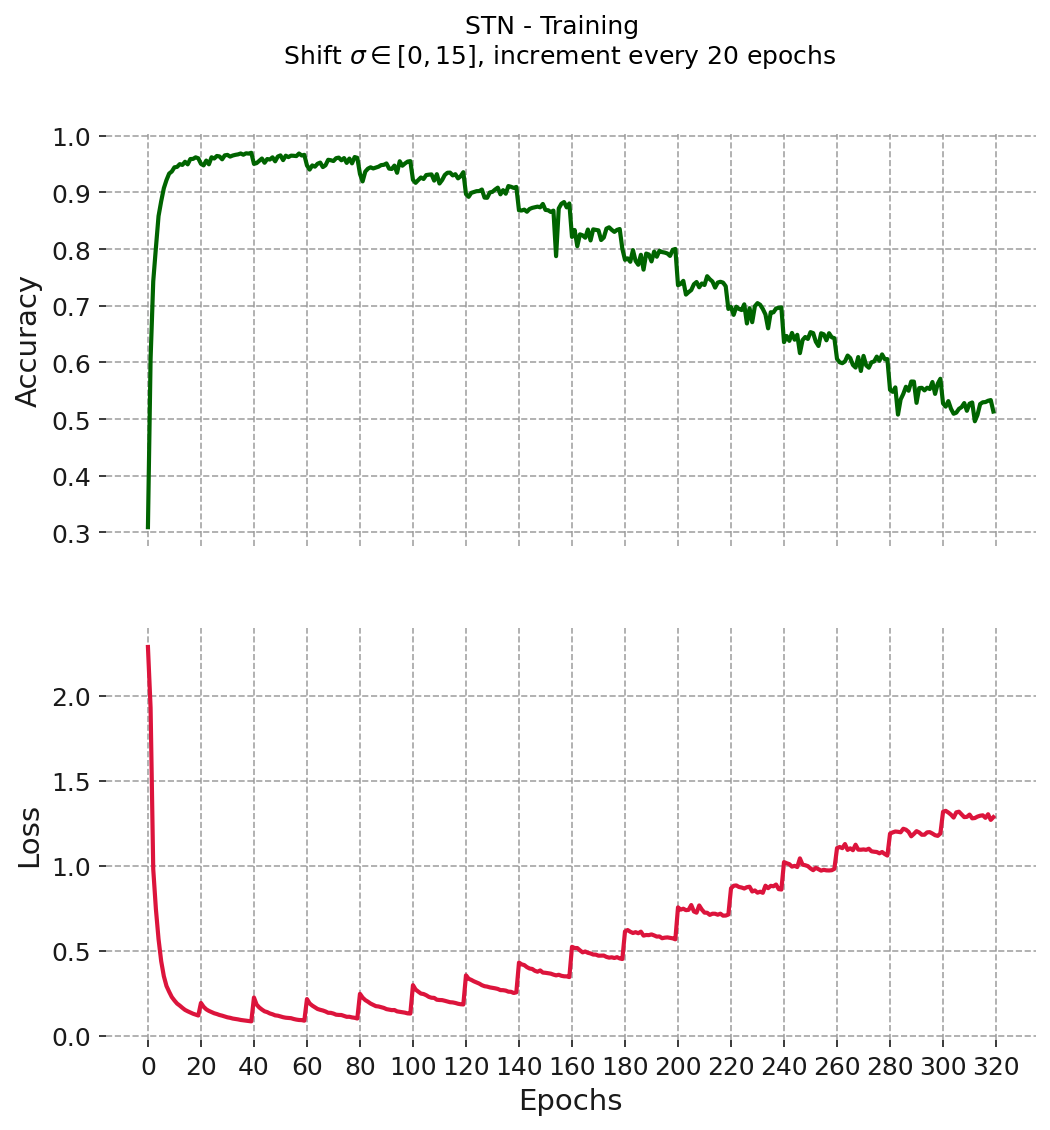

In [6]:
plt.style.use("gadfly")
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(8, 8))
ax[0].plot(acc_vals, 'darkgreen')
ax[1].plot(loss_vals, 'crimson')

for i in range(2):
    ax[i].set_xticks([e for e in range(0, 340, 20)])

ax[0].tick_params(axis='x',  which='both',  bottom=False,
                  top=False, labelbottom=False)
    
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")


#for i in range(2):
#    ax[i].grid(axis='x', linestyle='--')
fig.suptitle("STN - Training \n Shift $\sigma \in [0,15]$, increment every 20 epochs")
#fig.savefig('../figures/loss_acc_training_stn_28x28.png')

# Accuracy map

## Generating and saving the accuracy map

In [49]:
accuracy_map = np.zeros((55, 55))

In [51]:
for i in range(-27,28):
    for j in range(-27,28):
        transform=transforms.Compose([
                               WhatShift(args, i_offset=i, j_offset=j),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])
        test_loader = torch.utils.data.DataLoader(MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        ),
                        batch_size=args.minibatch_size,
                        shuffle=True)
        accuracy = test(test_loader)
        accuracy_map[i + 27, j + 27] = accuracy 
        print(i, j, accuracy)


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -24 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -22 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -21 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-27 -20 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-27 -19 0.1137

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-27 -18 0.1137

Test set: Average loss: 0.0230, Accuracy: 1140/10000 (11%)

-27 -17 0.114

Test set: Average loss: 0.0230, Accuracy: 1140/10000 (11%)

-27 -16 0.114

Test set: Average loss: 0.0230, Accuracy: 1146/10000 (11%)

-27 -15 0.1146

Test set: Ave


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -25 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-25 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-25 -23 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-25 -22 0.1138

Test set: Average loss: 0.0230, Accuracy: 1139/10000 (11%)

-25 -21 0.1139

Test set: Average loss: 0.0230, Accuracy: 1147/10000 (11%)

-25 -20 0.1147

Test set: Average loss: 0.0230, Accuracy: 1156/10000 (12%)

-25 -19 0.1156

Test set: Average loss: 0.0230, Accuracy: 1169/10000 (12%)

-25 -18 0.1169

Test set: Average loss: 0.0230, Accuracy: 1206/10000 (12%)

-25 -17 0.1206

Test set: Average loss: 0.0229, Accuracy: 1252/10000 (13%)

-25 -16 0.1252

Test set: Average loss: 0.0229, Accuracy: 1286/10000 (13%)

-25 -15 0.1286

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-23 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-23 -25 0.1138

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-23 -24 0.1136

Test set: Average loss: 0.0230, Accuracy: 1139/10000 (11%)

-23 -23 0.1139

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-23 -22 0.1145

Test set: Average loss: 0.0230, Accuracy: 1152/10000 (12%)

-23 -21 0.1152

Test set: Average loss: 0.0231, Accuracy: 1167/10000 (12%)

-23 -20 0.1167

Test set: Average loss: 0.0231, Accuracy: 1201/10000 (12%)

-23 -19 0.1201

Test set: Average loss: 0.0231, Accuracy: 1205/10000 (12%)

-23 -18 0.1205

Test set: Average loss: 0.0231, Accuracy: 1210/10000 (12%)

-23 -17 0.121

Test set: Average loss: 0.0231, Accuracy: 1184/10000 (12%)

-23 -16 0.1184

Test set: Average loss: 0.0231, Accuracy: 1145/10000 (11%)

-23 -15 0.1145

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-21 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-21 -25 0.1137

Test set: Average loss: 0.0231, Accuracy: 1136/10000 (11%)

-21 -24 0.1136

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-21 -23 0.1138

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-21 -22 0.1138

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

-21 -21 0.1156

Test set: Average loss: 0.0232, Accuracy: 1171/10000 (12%)

-21 -20 0.1171

Test set: Average loss: 0.0232, Accuracy: 1204/10000 (12%)

-21 -19 0.1204

Test set: Average loss: 0.0233, Accuracy: 1237/10000 (12%)

-21 -18 0.1237

Test set: Average loss: 0.0233, Accuracy: 1260/10000 (13%)

-21 -17 0.126

Test set: Average loss: 0.0232, Accuracy: 1247/10000 (12%)

-21 -16 0.1247

Test set: Average loss: 0.0232, Accuracy: 1244/10000 (12%)

-21 -15 0.1244

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-19 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-19 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-19 -25 0.1137

Test set: Average loss: 0.0231, Accuracy: 1138/10000 (11%)

-19 -24 0.1138

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

-19 -23 0.1148

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

-19 -22 0.1156

Test set: Average loss: 0.0232, Accuracy: 1180/10000 (12%)

-19 -21 0.118

Test set: Average loss: 0.0233, Accuracy: 1205/10000 (12%)

-19 -20 0.1205

Test set: Average loss: 0.0233, Accuracy: 1227/10000 (12%)

-19 -19 0.1227

Test set: Average loss: 0.0233, Accuracy: 1281/10000 (13%)

-19 -18 0.1281

Test set: Average loss: 0.0232, Accuracy: 1378/10000 (14%)

-19 -17 0.1378

Test set: Average loss: 0.0231, Accuracy: 1390/10000 (14%)

-19 -16 0.139

Test set: Average loss: 0.0230, Accuracy: 1314/10000 (13%)

-19 -15 0.1314

Test set: Ave


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-17 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-17 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1138/10000 (11%)

-17 -25 0.1138

Test set: Average loss: 0.0231, Accuracy: 1146/10000 (11%)

-17 -24 0.1146

Test set: Average loss: 0.0231, Accuracy: 1175/10000 (12%)

-17 -23 0.1175

Test set: Average loss: 0.0232, Accuracy: 1185/10000 (12%)

-17 -22 0.1185

Test set: Average loss: 0.0232, Accuracy: 1233/10000 (12%)

-17 -21 0.1233

Test set: Average loss: 0.0232, Accuracy: 1272/10000 (13%)

-17 -20 0.1272

Test set: Average loss: 0.0232, Accuracy: 1359/10000 (14%)

-17 -19 0.1359

Test set: Average loss: 0.0231, Accuracy: 1440/10000 (14%)

-17 -18 0.144

Test set: Average loss: 0.0230, Accuracy: 1466/10000 (15%)

-17 -17 0.1466

Test set: Average loss: 0.0229, Accuracy: 1424/10000 (14%)

-17 -16 0.1424

Test set: Average loss: 0.0228, Accuracy: 1328/10000 (13%)

-17 -15 0.1328

Test set: Av


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-15 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-15 -26 0.1136

Test set: Average loss: 0.0230, Accuracy: 1145/10000 (11%)

-15 -25 0.1145

Test set: Average loss: 0.0231, Accuracy: 1168/10000 (12%)

-15 -24 0.1168

Test set: Average loss: 0.0231, Accuracy: 1189/10000 (12%)

-15 -23 0.1189

Test set: Average loss: 0.0232, Accuracy: 1225/10000 (12%)

-15 -22 0.1225

Test set: Average loss: 0.0232, Accuracy: 1278/10000 (13%)

-15 -21 0.1278

Test set: Average loss: 0.0231, Accuracy: 1363/10000 (14%)

-15 -20 0.1363

Test set: Average loss: 0.0231, Accuracy: 1428/10000 (14%)

-15 -19 0.1428

Test set: Average loss: 0.0230, Accuracy: 1539/10000 (15%)

-15 -18 0.1539

Test set: Average loss: 0.0228, Accuracy: 1531/10000 (15%)

-15 -17 0.1531

Test set: Average loss: 0.0226, Accuracy: 1499/10000 (15%)

-15 -16 0.1499

Test set: Average loss: 0.0223, Accuracy: 1437/10000 (14%)

-15 -15 0.1437

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-13 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-13 -26 0.1135

Test set: Average loss: 0.0230, Accuracy: 1141/10000 (11%)

-13 -25 0.1141

Test set: Average loss: 0.0231, Accuracy: 1159/10000 (12%)

-13 -24 0.1159

Test set: Average loss: 0.0231, Accuracy: 1195/10000 (12%)

-13 -23 0.1195

Test set: Average loss: 0.0232, Accuracy: 1224/10000 (12%)

-13 -22 0.1224

Test set: Average loss: 0.0232, Accuracy: 1290/10000 (13%)

-13 -21 0.129

Test set: Average loss: 0.0231, Accuracy: 1421/10000 (14%)

-13 -20 0.1421

Test set: Average loss: 0.0230, Accuracy: 1520/10000 (15%)

-13 -19 0.152

Test set: Average loss: 0.0228, Accuracy: 1586/10000 (16%)

-13 -18 0.1586

Test set: Average loss: 0.0225, Accuracy: 1611/10000 (16%)

-13 -17 0.1611

Test set: Average loss: 0.0221, Accuracy: 1660/10000 (17%)

-13 -16 0.166

Test set: Average loss: 0.0214, Accuracy: 1947/10000 (19%)

-13 -15 0.1947

Test set: Aver


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-11 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

-11 -26 0.1136

Test set: Average loss: 0.0230, Accuracy: 1143/10000 (11%)

-11 -25 0.1143

Test set: Average loss: 0.0231, Accuracy: 1153/10000 (12%)

-11 -24 0.1153

Test set: Average loss: 0.0231, Accuracy: 1193/10000 (12%)

-11 -23 0.1193

Test set: Average loss: 0.0232, Accuracy: 1274/10000 (13%)

-11 -22 0.1274

Test set: Average loss: 0.0231, Accuracy: 1352/10000 (14%)

-11 -21 0.1352

Test set: Average loss: 0.0230, Accuracy: 1446/10000 (14%)

-11 -20 0.1446

Test set: Average loss: 0.0229, Accuracy: 1565/10000 (16%)

-11 -19 0.1565

Test set: Average loss: 0.0226, Accuracy: 1631/10000 (16%)

-11 -18 0.1631

Test set: Average loss: 0.0221, Accuracy: 1751/10000 (18%)

-11 -17 0.1751

Test set: Average loss: 0.0213, Accuracy: 2033/10000 (20%)

-11 -16 0.2033

Test set: Average loss: 0.0201, Accuracy: 2476/10000 (25%)

-11 -15 0.2476

Test set: A


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-9 -27 0.1135

Test set: Average loss: 0.0230, Accuracy: 1137/10000 (11%)

-9 -26 0.1137

Test set: Average loss: 0.0231, Accuracy: 1144/10000 (11%)

-9 -25 0.1144

Test set: Average loss: 0.0231, Accuracy: 1189/10000 (12%)

-9 -24 0.1189

Test set: Average loss: 0.0231, Accuracy: 1220/10000 (12%)

-9 -23 0.122

Test set: Average loss: 0.0231, Accuracy: 1289/10000 (13%)

-9 -22 0.1289

Test set: Average loss: 0.0231, Accuracy: 1382/10000 (14%)

-9 -21 0.1382

Test set: Average loss: 0.0230, Accuracy: 1494/10000 (15%)

-9 -20 0.1494

Test set: Average loss: 0.0227, Accuracy: 1615/10000 (16%)

-9 -19 0.1615

Test set: Average loss: 0.0222, Accuracy: 1826/10000 (18%)

-9 -18 0.1826

Test set: Average loss: 0.0214, Accuracy: 2030/10000 (20%)

-9 -17 0.203

Test set: Average loss: 0.0200, Accuracy: 2630/10000 (26%)

-9 -16 0.263

Test set: Average loss: 0.0180, Accuracy: 3406/10000 (34%)

-9 -15 0.3406

Test set: Average loss: 0.0


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

-7 -26 0.1135

Test set: Average loss: 0.0231, Accuracy: 1156/10000 (12%)

-7 -25 0.1156

Test set: Average loss: 0.0231, Accuracy: 1181/10000 (12%)

-7 -24 0.1181

Test set: Average loss: 0.0231, Accuracy: 1235/10000 (12%)

-7 -23 0.1235

Test set: Average loss: 0.0231, Accuracy: 1334/10000 (13%)

-7 -22 0.1334

Test set: Average loss: 0.0230, Accuracy: 1404/10000 (14%)

-7 -21 0.1404

Test set: Average loss: 0.0229, Accuracy: 1513/10000 (15%)

-7 -20 0.1513

Test set: Average loss: 0.0224, Accuracy: 1764/10000 (18%)

-7 -19 0.1764

Test set: Average loss: 0.0217, Accuracy: 2114/10000 (21%)

-7 -18 0.2114

Test set: Average loss: 0.0203, Accuracy: 2656/10000 (27%)

-7 -17 0.2656

Test set: Average loss: 0.0182, Accuracy: 3453/10000 (35%)

-7 -16 0.3453

Test set: Average loss: 0.0156, Accuracy: 4553/10000 (46%)

-7 -15 0.4553

Test set: Average loss: 0.0125, Accuracy: 5764/10000 (58%)

-7 -14 0.5764

Test set: Average loss: 


Test set: Average loss: 0.0230, Accuracy: 1151/10000 (12%)

-5 -25 0.1151

Test set: Average loss: 0.0231, Accuracy: 1180/10000 (12%)

-5 -24 0.118

Test set: Average loss: 0.0231, Accuracy: 1228/10000 (12%)

-5 -23 0.1228

Test set: Average loss: 0.0231, Accuracy: 1291/10000 (13%)

-5 -22 0.1291

Test set: Average loss: 0.0230, Accuracy: 1414/10000 (14%)

-5 -21 0.1414

Test set: Average loss: 0.0227, Accuracy: 1592/10000 (16%)

-5 -20 0.1592

Test set: Average loss: 0.0222, Accuracy: 1944/10000 (19%)

-5 -19 0.1944

Test set: Average loss: 0.0210, Accuracy: 2344/10000 (23%)

-5 -18 0.2344

Test set: Average loss: 0.0191, Accuracy: 3153/10000 (32%)

-5 -17 0.3153

Test set: Average loss: 0.0164, Accuracy: 4189/10000 (42%)

-5 -16 0.4189

Test set: Average loss: 0.0133, Accuracy: 5439/10000 (54%)

-5 -15 0.5439

Test set: Average loss: 0.0102, Accuracy: 6624/10000 (66%)

-5 -14 0.6624

Test set: Average loss: 0.0077, Accuracy: 7535/10000 (75%)

-5 -13 0.7535

Test set: Average loss: 0


Test set: Average loss: 0.0231, Accuracy: 1178/10000 (12%)

-3 -24 0.1178

Test set: Average loss: 0.0231, Accuracy: 1254/10000 (13%)

-3 -23 0.1254

Test set: Average loss: 0.0231, Accuracy: 1324/10000 (13%)

-3 -22 0.1324

Test set: Average loss: 0.0229, Accuracy: 1472/10000 (15%)

-3 -21 0.1472

Test set: Average loss: 0.0226, Accuracy: 1679/10000 (17%)

-3 -20 0.1679

Test set: Average loss: 0.0216, Accuracy: 2164/10000 (22%)

-3 -19 0.2164

Test set: Average loss: 0.0204, Accuracy: 2706/10000 (27%)

-3 -18 0.2706

Test set: Average loss: 0.0181, Accuracy: 3584/10000 (36%)

-3 -17 0.3584

Test set: Average loss: 0.0152, Accuracy: 4715/10000 (47%)

-3 -16 0.4715

Test set: Average loss: 0.0121, Accuracy: 5965/10000 (60%)

-3 -15 0.5965

Test set: Average loss: 0.0089, Accuracy: 7087/10000 (71%)

-3 -14 0.7087

Test set: Average loss: 0.0065, Accuracy: 7929/10000 (79%)

-3 -13 0.7929

Test set: Average loss: 0.0047, Accuracy: 8545/10000 (85%)

-3 -12 0.8545

Test set: Average loss: 


Test set: Average loss: 0.0231, Accuracy: 1213/10000 (12%)

-1 -23 0.1213

Test set: Average loss: 0.0230, Accuracy: 1302/10000 (13%)

-1 -22 0.1302

Test set: Average loss: 0.0228, Accuracy: 1486/10000 (15%)

-1 -21 0.1486

Test set: Average loss: 0.0224, Accuracy: 1817/10000 (18%)

-1 -20 0.1817

Test set: Average loss: 0.0214, Accuracy: 2293/10000 (23%)

-1 -19 0.2293

Test set: Average loss: 0.0199, Accuracy: 2937/10000 (29%)

-1 -18 0.2937

Test set: Average loss: 0.0176, Accuracy: 3859/10000 (39%)

-1 -17 0.3859

Test set: Average loss: 0.0144, Accuracy: 5024/10000 (50%)

-1 -16 0.5024

Test set: Average loss: 0.0111, Accuracy: 6334/10000 (63%)

-1 -15 0.6334

Test set: Average loss: 0.0082, Accuracy: 7334/10000 (73%)

-1 -14 0.7334

Test set: Average loss: 0.0059, Accuracy: 8140/10000 (81%)

-1 -13 0.814

Test set: Average loss: 0.0042, Accuracy: 8672/10000 (87%)

-1 -12 0.8672

Test set: Average loss: 0.0031, Accuracy: 9074/10000 (91%)

-1 -11 0.9074

Test set: Average loss: 0


Test set: Average loss: 0.0228, Accuracy: 1543/10000 (15%)

1 -21 0.1543

Test set: Average loss: 0.0223, Accuracy: 1831/10000 (18%)

1 -20 0.1831

Test set: Average loss: 0.0214, Accuracy: 2327/10000 (23%)

1 -19 0.2327

Test set: Average loss: 0.0197, Accuracy: 3027/10000 (30%)

1 -18 0.3027

Test set: Average loss: 0.0172, Accuracy: 4043/10000 (40%)

1 -17 0.4043

Test set: Average loss: 0.0139, Accuracy: 5233/10000 (52%)

1 -16 0.5233

Test set: Average loss: 0.0107, Accuracy: 6474/10000 (65%)

1 -15 0.6474

Test set: Average loss: 0.0078, Accuracy: 7489/10000 (75%)

1 -14 0.7489

Test set: Average loss: 0.0057, Accuracy: 8197/10000 (82%)

1 -13 0.8197

Test set: Average loss: 0.0042, Accuracy: 8721/10000 (87%)

1 -12 0.8721

Test set: Average loss: 0.0030, Accuracy: 9064/10000 (91%)

1 -11 0.9064

Test set: Average loss: 0.0021, Accuracy: 9347/10000 (93%)

1 -10 0.9347

Test set: Average loss: 0.0016, Accuracy: 9505/10000 (95%)

1 -9 0.9505

Test set: Average loss: 0.0013, Accura


Test set: Average loss: 0.0196, Accuracy: 3082/10000 (31%)

3 -18 0.3082

Test set: Average loss: 0.0171, Accuracy: 4053/10000 (41%)

3 -17 0.4053

Test set: Average loss: 0.0140, Accuracy: 5160/10000 (52%)

3 -16 0.516

Test set: Average loss: 0.0108, Accuracy: 6437/10000 (64%)

3 -15 0.6437

Test set: Average loss: 0.0078, Accuracy: 7487/10000 (75%)

3 -14 0.7487

Test set: Average loss: 0.0060, Accuracy: 8084/10000 (81%)

3 -13 0.8084

Test set: Average loss: 0.0043, Accuracy: 8689/10000 (87%)

3 -12 0.8689

Test set: Average loss: 0.0031, Accuracy: 9054/10000 (91%)

3 -11 0.9054

Test set: Average loss: 0.0022, Accuracy: 9300/10000 (93%)

3 -10 0.93

Test set: Average loss: 0.0017, Accuracy: 9471/10000 (95%)

3 -9 0.9471

Test set: Average loss: 0.0014, Accuracy: 9562/10000 (96%)

3 -8 0.9562

Test set: Average loss: 0.0012, Accuracy: 9607/10000 (96%)

3 -7 0.9607

Test set: Average loss: 0.0012, Accuracy: 9640/10000 (96%)

3 -6 0.964

Test set: Average loss: 0.0011, Accuracy: 964


Test set: Average loss: 0.0116, Accuracy: 6130/10000 (61%)

5 -15 0.613

Test set: Average loss: 0.0087, Accuracy: 7168/10000 (72%)

5 -14 0.7168

Test set: Average loss: 0.0067, Accuracy: 7860/10000 (79%)

5 -13 0.786

Test set: Average loss: 0.0049, Accuracy: 8412/10000 (84%)

5 -12 0.8412

Test set: Average loss: 0.0037, Accuracy: 8830/10000 (88%)

5 -11 0.883

Test set: Average loss: 0.0027, Accuracy: 9132/10000 (91%)

5 -10 0.9132

Test set: Average loss: 0.0021, Accuracy: 9322/10000 (93%)

5 -9 0.9322

Test set: Average loss: 0.0018, Accuracy: 9468/10000 (95%)

5 -8 0.9468

Test set: Average loss: 0.0016, Accuracy: 9471/10000 (95%)

5 -7 0.9471

Test set: Average loss: 0.0015, Accuracy: 9523/10000 (95%)

5 -6 0.9523

Test set: Average loss: 0.0014, Accuracy: 9546/10000 (95%)

5 -5 0.9546

Test set: Average loss: 0.0014, Accuracy: 9558/10000 (96%)

5 -4 0.9558

Test set: Average loss: 0.0013, Accuracy: 9539/10000 (95%)

5 -3 0.9539

Test set: Average loss: 0.0013, Accuracy: 9581/


Test set: Average loss: 0.0063, Accuracy: 7954/10000 (80%)

7 -12 0.7954

Test set: Average loss: 0.0049, Accuracy: 8419/10000 (84%)

7 -11 0.8419

Test set: Average loss: 0.0038, Accuracy: 8729/10000 (87%)

7 -10 0.8729

Test set: Average loss: 0.0031, Accuracy: 8971/10000 (90%)

7 -9 0.8971

Test set: Average loss: 0.0026, Accuracy: 9125/10000 (91%)

7 -8 0.9125

Test set: Average loss: 0.0024, Accuracy: 9188/10000 (92%)

7 -7 0.9188

Test set: Average loss: 0.0021, Accuracy: 9290/10000 (93%)

7 -6 0.929

Test set: Average loss: 0.0021, Accuracy: 9327/10000 (93%)

7 -5 0.9327

Test set: Average loss: 0.0020, Accuracy: 9346/10000 (93%)

7 -4 0.9346

Test set: Average loss: 0.0019, Accuracy: 9389/10000 (94%)

7 -3 0.9389

Test set: Average loss: 0.0019, Accuracy: 9352/10000 (94%)

7 -2 0.9352

Test set: Average loss: 0.0019, Accuracy: 9408/10000 (94%)

7 -1 0.9408

Test set: Average loss: 0.0019, Accuracy: 9375/10000 (94%)

7 0 0.9375

Test set: Average loss: 0.0018, Accuracy: 9380/10


Test set: Average loss: 0.0043, Accuracy: 8591/10000 (86%)

9 -9 0.8591

Test set: Average loss: 0.0038, Accuracy: 8755/10000 (88%)

9 -8 0.8755

Test set: Average loss: 0.0035, Accuracy: 8850/10000 (88%)

9 -7 0.885

Test set: Average loss: 0.0032, Accuracy: 8932/10000 (89%)

9 -6 0.8932

Test set: Average loss: 0.0029, Accuracy: 9017/10000 (90%)

9 -5 0.9017

Test set: Average loss: 0.0028, Accuracy: 9038/10000 (90%)

9 -4 0.9038

Test set: Average loss: 0.0028, Accuracy: 9091/10000 (91%)

9 -3 0.9091

Test set: Average loss: 0.0026, Accuracy: 9112/10000 (91%)

9 -2 0.9112

Test set: Average loss: 0.0026, Accuracy: 9128/10000 (91%)

9 -1 0.9128

Test set: Average loss: 0.0025, Accuracy: 9156/10000 (92%)

9 0 0.9156

Test set: Average loss: 0.0024, Accuracy: 9174/10000 (92%)

9 1 0.9174

Test set: Average loss: 0.0024, Accuracy: 9174/10000 (92%)

9 2 0.9174

Test set: Average loss: 0.0024, Accuracy: 9189/10000 (92%)

9 3 0.9189

Test set: Average loss: 0.0025, Accuracy: 9143/10000 (9


Test set: Average loss: 0.0047, Accuracy: 8407/10000 (84%)

11 -7 0.8407

Test set: Average loss: 0.0045, Accuracy: 8497/10000 (85%)

11 -6 0.8497

Test set: Average loss: 0.0041, Accuracy: 8658/10000 (87%)

11 -5 0.8658

Test set: Average loss: 0.0040, Accuracy: 8654/10000 (87%)

11 -4 0.8654

Test set: Average loss: 0.0038, Accuracy: 8724/10000 (87%)

11 -3 0.8724

Test set: Average loss: 0.0037, Accuracy: 8763/10000 (88%)

11 -2 0.8763

Test set: Average loss: 0.0036, Accuracy: 8796/10000 (88%)

11 -1 0.8796

Test set: Average loss: 0.0034, Accuracy: 8836/10000 (88%)

11 0 0.8836

Test set: Average loss: 0.0034, Accuracy: 8846/10000 (88%)

11 1 0.8846

Test set: Average loss: 0.0034, Accuracy: 8846/10000 (88%)

11 2 0.8846

Test set: Average loss: 0.0034, Accuracy: 8816/10000 (88%)

11 3 0.8816

Test set: Average loss: 0.0035, Accuracy: 8751/10000 (88%)

11 4 0.8751

Test set: Average loss: 0.0036, Accuracy: 8802/10000 (88%)

11 5 0.8802

Test set: Average loss: 0.0038, Accuracy: 8


Test set: Average loss: 0.0066, Accuracy: 7716/10000 (77%)

13 -6 0.7716

Test set: Average loss: 0.0063, Accuracy: 7850/10000 (78%)

13 -5 0.785

Test set: Average loss: 0.0060, Accuracy: 7945/10000 (79%)

13 -4 0.7945

Test set: Average loss: 0.0057, Accuracy: 8044/10000 (80%)

13 -3 0.8044

Test set: Average loss: 0.0056, Accuracy: 8046/10000 (80%)

13 -2 0.8046

Test set: Average loss: 0.0056, Accuracy: 8079/10000 (81%)

13 -1 0.8079

Test set: Average loss: 0.0055, Accuracy: 8098/10000 (81%)

13 0 0.8098

Test set: Average loss: 0.0053, Accuracy: 8150/10000 (82%)

13 1 0.815

Test set: Average loss: 0.0052, Accuracy: 8184/10000 (82%)

13 2 0.8184

Test set: Average loss: 0.0052, Accuracy: 8192/10000 (82%)

13 3 0.8192

Test set: Average loss: 0.0054, Accuracy: 8147/10000 (81%)

13 4 0.8147

Test set: Average loss: 0.0056, Accuracy: 8045/10000 (80%)

13 5 0.8045

Test set: Average loss: 0.0060, Accuracy: 7863/10000 (79%)

13 6 0.7863

Test set: Average loss: 0.0066, Accuracy: 7681


Test set: Average loss: 0.0094, Accuracy: 6730/10000 (67%)

15 -5 0.673

Test set: Average loss: 0.0090, Accuracy: 6830/10000 (68%)

15 -4 0.683

Test set: Average loss: 0.0088, Accuracy: 6936/10000 (69%)

15 -3 0.6936

Test set: Average loss: 0.0085, Accuracy: 7015/10000 (70%)

15 -2 0.7015

Test set: Average loss: 0.0084, Accuracy: 7058/10000 (71%)

15 -1 0.7058

Test set: Average loss: 0.0083, Accuracy: 7098/10000 (71%)

15 0 0.7098

Test set: Average loss: 0.0083, Accuracy: 7061/10000 (71%)

15 1 0.7061

Test set: Average loss: 0.0081, Accuracy: 7175/10000 (72%)

15 2 0.7175

Test set: Average loss: 0.0082, Accuracy: 7097/10000 (71%)

15 3 0.7097

Test set: Average loss: 0.0085, Accuracy: 7046/10000 (70%)

15 4 0.7046

Test set: Average loss: 0.0087, Accuracy: 6956/10000 (70%)

15 5 0.6956

Test set: Average loss: 0.0093, Accuracy: 6678/10000 (67%)

15 6 0.6678

Test set: Average loss: 0.0101, Accuracy: 6471/10000 (65%)

15 7 0.6471

Test set: Average loss: 0.0110, Accuracy: 6085/


Test set: Average loss: 0.0128, Accuracy: 5493/10000 (55%)

17 -4 0.5493

Test set: Average loss: 0.0125, Accuracy: 5645/10000 (56%)

17 -3 0.5645

Test set: Average loss: 0.0123, Accuracy: 5679/10000 (57%)

17 -2 0.5679

Test set: Average loss: 0.0122, Accuracy: 5714/10000 (57%)

17 -1 0.5714

Test set: Average loss: 0.0121, Accuracy: 5763/10000 (58%)

17 0 0.5763

Test set: Average loss: 0.0120, Accuracy: 5837/10000 (58%)

17 1 0.5837

Test set: Average loss: 0.0120, Accuracy: 5813/10000 (58%)

17 2 0.5813

Test set: Average loss: 0.0123, Accuracy: 5735/10000 (57%)

17 3 0.5735

Test set: Average loss: 0.0126, Accuracy: 5627/10000 (56%)

17 4 0.5627

Test set: Average loss: 0.0130, Accuracy: 5430/10000 (54%)

17 5 0.543

Test set: Average loss: 0.0136, Accuracy: 5148/10000 (51%)

17 6 0.5148

Test set: Average loss: 0.0145, Accuracy: 4877/10000 (49%)

17 7 0.4877

Test set: Average loss: 0.0153, Accuracy: 4539/10000 (45%)

17 8 0.4539

Test set: Average loss: 0.0162, Accuracy: 4281/


Test set: Average loss: 0.0169, Accuracy: 3877/10000 (39%)

19 -3 0.3877

Test set: Average loss: 0.0167, Accuracy: 3968/10000 (40%)

19 -2 0.3968

Test set: Average loss: 0.0164, Accuracy: 4174/10000 (42%)

19 -1 0.4174

Test set: Average loss: 0.0163, Accuracy: 4193/10000 (42%)

19 0 0.4193

Test set: Average loss: 0.0164, Accuracy: 4195/10000 (42%)

19 1 0.4195

Test set: Average loss: 0.0165, Accuracy: 4092/10000 (41%)

19 2 0.4092

Test set: Average loss: 0.0167, Accuracy: 4066/10000 (41%)

19 3 0.4066

Test set: Average loss: 0.0170, Accuracy: 3868/10000 (39%)

19 4 0.3868

Test set: Average loss: 0.0174, Accuracy: 3764/10000 (38%)

19 5 0.3764

Test set: Average loss: 0.0178, Accuracy: 3502/10000 (35%)

19 6 0.3502

Test set: Average loss: 0.0183, Accuracy: 3358/10000 (34%)

19 7 0.3358

Test set: Average loss: 0.0189, Accuracy: 3194/10000 (32%)

19 8 0.3194

Test set: Average loss: 0.0195, Accuracy: 2901/10000 (29%)

19 9 0.2901

Test set: Average loss: 0.0200, Accuracy: 2800/


Test set: Average loss: 0.0210, Accuracy: 1850/10000 (18%)

21 -2 0.185

Test set: Average loss: 0.0210, Accuracy: 1832/10000 (18%)

21 -1 0.1832

Test set: Average loss: 0.0211, Accuracy: 1764/10000 (18%)

21 0 0.1764

Test set: Average loss: 0.0211, Accuracy: 1735/10000 (17%)

21 1 0.1735

Test set: Average loss: 0.0211, Accuracy: 1686/10000 (17%)

21 2 0.1686

Test set: Average loss: 0.0212, Accuracy: 1599/10000 (16%)

21 3 0.1599

Test set: Average loss: 0.0214, Accuracy: 1469/10000 (15%)

21 4 0.1469

Test set: Average loss: 0.0216, Accuracy: 1471/10000 (15%)

21 5 0.1471

Test set: Average loss: 0.0217, Accuracy: 1421/10000 (14%)

21 6 0.1421

Test set: Average loss: 0.0217, Accuracy: 1511/10000 (15%)

21 7 0.1511

Test set: Average loss: 0.0219, Accuracy: 1594/10000 (16%)

21 8 0.1594

Test set: Average loss: 0.0220, Accuracy: 1614/10000 (16%)

21 9 0.1614

Test set: Average loss: 0.0221, Accuracy: 1625/10000 (16%)

21 10 0.1625

Test set: Average loss: 0.0223, Accuracy: 1567/1


Test set: Average loss: 0.0231, Accuracy: 934/10000 (9%)

23 0 0.0934

Test set: Average loss: 0.0231, Accuracy: 915/10000 (9%)

23 1 0.0915

Test set: Average loss: 0.0232, Accuracy: 900/10000 (9%)

23 2 0.09

Test set: Average loss: 0.0233, Accuracy: 880/10000 (9%)

23 3 0.088

Test set: Average loss: 0.0233, Accuracy: 862/10000 (9%)

23 4 0.0862

Test set: Average loss: 0.0233, Accuracy: 908/10000 (9%)

23 5 0.0908

Test set: Average loss: 0.0233, Accuracy: 900/10000 (9%)

23 6 0.09

Test set: Average loss: 0.0233, Accuracy: 915/10000 (9%)

23 7 0.0915

Test set: Average loss: 0.0232, Accuracy: 927/10000 (9%)

23 8 0.0927

Test set: Average loss: 0.0232, Accuracy: 934/10000 (9%)

23 9 0.0934

Test set: Average loss: 0.0232, Accuracy: 957/10000 (10%)

23 10 0.0957

Test set: Average loss: 0.0232, Accuracy: 949/10000 (9%)

23 11 0.0949

Test set: Average loss: 0.0232, Accuracy: 967/10000 (10%)

23 12 0.0967

Test set: Average loss: 0.0232, Accuracy: 1024/10000 (10%)

23 13 0.1024

Te


Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

25 1 0.1137

Test set: Average loss: 0.0231, Accuracy: 1146/10000 (11%)

25 2 0.1146

Test set: Average loss: 0.0231, Accuracy: 1143/10000 (11%)

25 3 0.1143

Test set: Average loss: 0.0231, Accuracy: 1148/10000 (11%)

25 4 0.1148

Test set: Average loss: 0.0231, Accuracy: 1142/10000 (11%)

25 5 0.1142

Test set: Average loss: 0.0231, Accuracy: 1141/10000 (11%)

25 6 0.1141

Test set: Average loss: 0.0231, Accuracy: 1142/10000 (11%)

25 7 0.1142

Test set: Average loss: 0.0231, Accuracy: 1140/10000 (11%)

25 8 0.114

Test set: Average loss: 0.0231, Accuracy: 1141/10000 (11%)

25 9 0.1141

Test set: Average loss: 0.0231, Accuracy: 1137/10000 (11%)

25 10 0.1137

Test set: Average loss: 0.0231, Accuracy: 1134/10000 (11%)

25 11 0.1134

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

25 12 0.1136

Test set: Average loss: 0.0230, Accuracy: 1136/10000 (11%)

25 13 0.1136

Test set: Average loss: 0.0230, Accuracy: 1135/


Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 2 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 3 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 4 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 5 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 6 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 7 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 8 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 9 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 10 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 11 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 12 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 13 0.1135

Test set: Average loss: 0.0230, Accuracy: 1135/10000 (11%)

27 14 0.1135

Test set: Average loss: 0.0230, Accuracy: 113

In [7]:
MAP_PATH = "../models/acc_map_stn_28x28_sgd.npy"

In [59]:
#np.save(MAP_PATH, accuracy_map)

## Loading the map and visualisation

In [8]:
accuracy_map = np.load(MAP_PATH)

In [9]:
accuracy_map

array([[0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       ...,
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135],
       [0.1135, 0.1135, 0.1135, ..., 0.1135, 0.1135, 0.1135]])

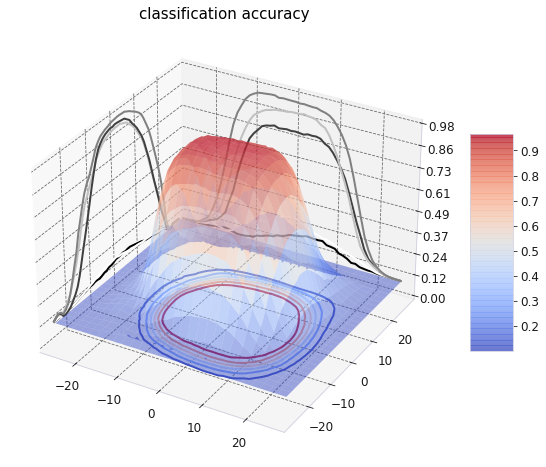

In [11]:
plt.style.use("gadfly")
fig = plt.figure(figsize=(10,8))

for i in range(55):
    for j in range(55):
        accuracy_map[i,j] = max(accuracy_map[i,j], 0.1) # taking out values that are less than 10%

ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid of coordinates
X = np.arange(-27, 28)
Y = np.arange(-27, 28)
X, Y = np.meshgrid(X, Y) 

surf = ax.plot_surface(X, Y, accuracy_map, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, alpha=0.5)

#ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, accuracy_map, [0.2, 0.3, 0.4, 0.5, 0.6, 0.7], zdir='z', offset=0, cmap=cm.coolwarm, alpha = 1)
cset = ax.contour(X, Y, accuracy_map, [-20, -10, 0, 10, 20], zdir='x', offset=-27.5, cmap = 'gray')
cset = ax.contour(X, Y, accuracy_map,  [-20, -10, 0, 10, 20], zdir='y', offset=27.5, cmap = 'gray')


# Customize the z axis.
ax.set_xlim(-27.5, 27.5)
ax.set_zlim(-27.5, 27.5)
ax.set_zlim(0, 0.98)
ax.zaxis.set_major_locator(LinearLocator(9))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('classification accuracy', size=15)

# Add a color bar which maps values to colors.
cbar = fig.colorbar(surf, shrink=0.5, aspect=5, ticks=[0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9])
#fig.savefig('../figures/stn_28x28_accuracy_map.png', bbox_inches='tight', pad_inches=0.1)